In [45]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [46]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \sum_{j}^J \pi_j\mu_{2,j}) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_{2,j})+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left(-\frac{1}{\xi_a}\left[(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right) + \frac{\partial \phi}{\partial z_2}(y, z_2)\rho \mu_{2,j}\right]\right)\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2 + (\eta-1)\sum_{j}^J \pi_j \frac{d}{d \tau}\Lambda_j(z_2 y)\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(z_2 y)z_2}
$$

In [75]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat
    d_Λ = np.array([λ_1 + λ_2*y_mat*z_mat + 
                            λ_2p_j*(y_mat*z_mat>λ_bar)*(y_mat*z_mat-λ_bar) for λ_2p_j in λ_2p])
    dd_Λ = np.array([λ_2 + λ_2p_j*(y_mat*z_mat>λ_bar) for λ_2p_j in λ_2p])
    d_Λ_yz_sigma = d_Λ*y_mat*np.sqrt(z_mat)*σ_2
    d_Λ_z = d_Λ*z_mat

    π = np.ones_like(d_Λ)
    μ_2_new = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
        μ_2_new[i] = μ_2[i]
    π_o = π.copy()
    μ_2 = μ_2_new.copy()
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))    

    mean_reversion = - y_mat*ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    std_y = y_mat*std
    variance = z_mat*y_mat**2*σ_2**2

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        temp = d_Λ*(z_mat*e + mean_reversion) + 0.5*dd_Λ*variance
        log_π_ratio = -((η-1.)*temp + v0_dz*ρ*μ_2)/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12
        
        e = - δ*η / (v0_dy + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e[e<=0] = 1e-12

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - np.sum(π*μ_2, axis=0))
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*np.sum(π*temp, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [78]:
# Model parameters
η = .032
ξ_a = 1./4000
δ = .01
# Z process
μ_2_mean = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2 / 3.
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# two damage
λ_2p_original = np.array([0., 0.0197*2])
μ_2_original = pd.read_csv('../data/model153.csv', header=None).to_numpy()[:, 0]/1000.

λ_2p = np.zeros(λ_2p_original.shape[0]*μ_2_original.shape[0])
μ_2 = np.zeros_like(λ_2p)
π_o = np.zeros_like(λ_2p)
for i in range(λ_2p_original.shape[0]):
    for j in range(μ_2_original.shape[0]):
        idx = i*μ_2_original.shape[0] + j
        λ_2p[idx] = λ_2p_original[i]
        μ_2[idx] = μ_2_original[j]
        π_o[idx] = 1./len(π_o)

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2_mean - 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ)), 1e-9])
z_max = μ_2_mean + 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [79]:
ϕ_grid, e_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.3642099353796533; RHS Error 0.40932959331232843
Iteration 2: LHS Error: 0.312600920023554; RHS Error 0.36224306264794315
Iteration 3: LHS Error: 0.27168051588716446; RHS Error 0.3113219719313719
Iteration 4: LHS Error: 0.24186186371291063; RHS Error 0.2707893602453205
Iteration 5: LHS Error: 0.22084361888249937; RHS Error 0.24127616472249774
Iteration 6: LHS Error: 0.20611008961526434; RHS Error 0.22047944551014906
Iteration 7: LHS Error: 0.1955357528570265; RHS Error 0.20590219610931731
Iteration 8: LHS Error: 0.1880374781699201; RHS Error 0.19543553562343605
Iteration 9: LHS Error: 0.1826016519966971; RHS Error 0.18801441875886551
Iteration 10: LHS Error: 0.1786428523284851; RHS Error 0.18263232492708217
Iteration 11: LHS Error: 0.17569752238113434; RHS Error 0.17871190705281148
Iteration 12: LHS Error: 0.17337912025398516; RHS Error 0.17579427118536134
Iteration 13: LHS Error: 0.17147833587348416; RHS Error 0.173495953348836
Iteration 14: LHS Error: 0.17002

Iteration 111: LHS Error: 0.10443850747099859; RHS Error 0.10542509765578711
Iteration 112: LHS Error: 0.1039250659978066; RHS Error 0.10491176398300534
Iteration 113: LHS Error: 0.10341410990737998; RHS Error 0.10440091370877469
Iteration 114: LHS Error: 0.10290562675789161; RHS Error 0.10389253584523817
Iteration 115: LHS Error: 0.10239960185553798; RHS Error 0.10338661811802913
Iteration 116: LHS Error: 0.10189602818025634; RHS Error 0.1028831487601542
Iteration 117: LHS Error: 0.10139489517133882; RHS Error 0.1023821145871665
Iteration 118: LHS Error: 0.10089618992925509; RHS Error 0.10188350851867872
Iteration 119: LHS Error: 0.10039990075812; RHS Error 0.10138731813941937
Iteration 120: LHS Error: 0.09990601634968854; RHS Error 0.10089353154650482
Iteration 121: LHS Error: 0.09941452607997192; RHS Error 0.10040213764198141
Iteration 122: LHS Error: 0.09892541847332126; RHS Error 0.09991312521300849
Iteration 123: LHS Error: 0.09843868228211505; RHS Error 0.09942648352828987
Itera

Iteration 220: LHS Error: 0.0608430244585243; RHS Error 0.061833879741310216
Iteration 221: LHS Error: 0.060543627673602884; RHS Error 0.06153452545469029
Iteration 222: LHS Error: 0.06024569244276279; RHS Error 0.06123663226187831
Iteration 223: LHS Error: 0.0599492118562992; RHS Error 0.060940193206805604
Iteration 224: LHS Error: 0.05965417900529957; RHS Error 0.060645201277661265
Iteration 225: LHS Error: 0.05936058688453372; RHS Error 0.06035164967265211
Iteration 226: LHS Error: 0.059068428618331836; RHS Error 0.06005953142936871
Iteration 227: LHS Error: 0.058777697479303725; RHS Error 0.05976883975112157
Iteration 228: LHS Error: 0.05848838658223343; RHS Error 0.05947956801586235
Iteration 229: LHS Error: 0.05820048918149112; RHS Error 0.05919170928053574
Iteration 230: LHS Error: 0.057913998495326524; RHS Error 0.05890525672637836
Iteration 231: LHS Error: 0.05762890772378526; RHS Error 0.05862020364096798
Iteration 232: LHS Error: 0.05734521041018681; RHS Error 0.058336543550

Iteration 328: LHS Error: 0.03568443772754293; RHS Error 0.03667797555605812
Iteration 329: LHS Error: 0.03550837089352399; RHS Error 0.036501922186382596
Iteration 330: LHS Error: 0.03533317003816805; RHS Error 0.03632673475633752
Iteration 331: LHS Error: 0.035158831179508354; RHS Error 0.03615240947592363
Iteration 332: LHS Error: 0.034985349882799; RHS Error 0.03597894137431901
Iteration 333: LHS Error: 0.03481272217372933; RHS Error 0.03580632668457712
Iteration 334: LHS Error: 0.0346409436721693; RHS Error 0.035634561328751535
Iteration 335: LHS Error: 0.034470010449624056; RHS Error 0.035463641061746765
Iteration 336: LHS Error: 0.03429991810868671; RHS Error 0.03529356167920039
Iteration 337: LHS Error: 0.03413066284419486; RHS Error 0.035124318884665995
Iteration 338: LHS Error: 0.03396224027193995; RHS Error 0.03495590879962185
Iteration 339: LHS Error: 0.03379464662423359; RHS Error 0.034788327917493644
Iteration 340: LHS Error: 0.033627877649831106; RHS Error 0.034621571206

Iteration 436: LHS Error: 0.0209092771452859; RHS Error 0.021903783389296105
Iteration 437: LHS Error: 0.020805997318603886; RHS Error 0.02180050933688965
Iteration 438: LHS Error: 0.020703226961863663; RHS Error 0.02169774445247763
Iteration 439: LHS Error: 0.02060096363263142; RHS Error 0.021595486673897157
Iteration 440: LHS Error: 0.02049920475897693; RHS Error 0.02149373339980154
Iteration 441: LHS Error: 0.020397947728547194; RHS Error 0.021392481950237185
Iteration 442: LHS Error: 0.020297190243553587; RHS Error 0.021291729930925707
Iteration 443: LHS Error: 0.020196929810794018; RHS Error 0.021191475017406203
Iteration 444: LHS Error: 0.02009716401973094; RHS Error 0.021091714500594883
Iteration 445: LHS Error: 0.01999789039137312; RHS Error 0.020992446212324933
Iteration 446: LHS Error: 0.01989910652703486; RHS Error 0.02089366770677714
Iteration 447: LHS Error: 0.019800810033693494; RHS Error 0.020795376397636733
Iteration 448: LHS Error: 0.019702998471174737; RHS Error 0.020

Iteration 544: LHS Error: 0.012246768234433603; RHS Error 0.013241705855241315
Iteration 545: LHS Error: 0.012186245667464846; RHS Error 0.01318118606242874
Iteration 546: LHS Error: 0.012126022043659646; RHS Error 0.013120965157138953
Iteration 547: LHS Error: 0.012066095866714477; RHS Error 0.013061041668749829
Iteration 548: LHS Error: 0.01200646557017393; RHS Error 0.013001414106270537
Iteration 549: LHS Error: 0.011947130040525167; RHS Error 0.012942081343757239
Iteration 550: LHS Error: 0.011888087619624343; RHS Error 0.01288304144059449
Iteration 551: LHS Error: 0.011829336453274664; RHS Error 0.01282429272399549
Iteration 552: LHS Error: 0.01177087550701117; RHS Error 0.012765834607462834
Iteration 553: LHS Error: 0.011712701300773176; RHS Error 0.012707664987315848
Iteration 554: LHS Error: 0.011654815915427719; RHS Error 0.012649781515663872
Iteration 555: LHS Error: 0.011597216976888092; RHS Error 0.012592184650308758
Iteration 556: LHS Error: 0.011539902314495976; RHS Error

Iteration 652: LHS Error: 0.007171691125627433; RHS Error 0.00816684498807041
Iteration 653: LHS Error: 0.00713624107162758; RHS Error 0.008131396302101246
Iteration 654: LHS Error: 0.007100966145678456; RHS Error 0.00809612282241251
Iteration 655: LHS Error: 0.007065865470487154; RHS Error 0.008061023709546145
Iteration 656: LHS Error: 0.0070309383521305335; RHS Error 0.00802609791351705
Iteration 657: LHS Error: 0.006996183824334423; RHS Error 0.007991344882621654
Iteration 658: LHS Error: 0.0069616010383981575; RHS Error 0.0079567633734145
Iteration 659: LHS Error: 0.006927189106377796; RHS Error 0.007922352971939328
Iteration 660: LHS Error: 0.00689294741412283; RHS Error 0.007888112363070632
Iteration 661: LHS Error: 0.006858874727249997; RHS Error 0.007854041322263416
Iteration 662: LHS Error: 0.006824970471178915; RHS Error 0.007820138407666433
Iteration 663: LHS Error: 0.006791233833993715; RHS Error 0.007786403012690735
Iteration 664: LHS Error: 0.0067576637225243985; RHS Erro

Iteration 756: LHS Error: 0.004283446528440038; RHS Error 0.005278718972435592
Iteration 757: LHS Error: 0.004262272219058616; RHS Error 0.005257541941352584
Iteration 758: LHS Error: 0.004241205674375692; RHS Error 0.005236471144340504
Iteration 759: LHS Error: 0.004220241546413206; RHS Error 0.0052155071630968775
Iteration 760: LHS Error: 0.004199380833263433; RHS Error 0.005194646885819221
Iteration 761: LHS Error: 0.004178613132239661; RHS Error 0.005173889887250482
Iteration 762: LHS Error: 0.004157957143156921; RHS Error 0.005153230951897958
Iteration 763: LHS Error: 0.004137405952796769; RHS Error 0.00513267559919478
Iteration 764: LHS Error: 0.0041169547777499815; RHS Error 0.005112224672458365
Iteration 765: LHS Error: 0.004096604488061928; RHS Error 0.005091874616024894
Iteration 766: LHS Error: 0.004076344750082228; RHS Error 0.005071625637492416
Iteration 767: LHS Error: 0.004056194398387447; RHS Error 0.005051472127335921
Iteration 768: LHS Error: 0.0040361460905415925; RH

Iteration 860: LHS Error: 0.002558330183575208; RHS Error 0.003553660910000589
Iteration 861: LHS Error: 0.0025456817364357676; RHS Error 0.003541014555871136
Iteration 862: LHS Error: 0.00253309671614943; RHS Error 0.0035284299162648414
Iteration 863: LHS Error: 0.0025205736805204992; RHS Error 0.0035159076269608014
Iteration 864: LHS Error: 0.0025081131261828205; RHS Error 0.0035034468900714266
Iteration 865: LHS Error: 0.002495714140835048; RHS Error 0.003491047820543658
Iteration 866: LHS Error: 0.0024833765497049853; RHS Error 0.0034787105180349442
Iteration 867: LHS Error: 0.002471099875990035; RHS Error 0.003466434258775908
Iteration 868: LHS Error: 0.0024588839388215433; RHS Error 0.0034542187861976714
Iteration 869: LHS Error: 0.0024467283913196525; RHS Error 0.003442063606162671
Iteration 870: LHS Error: 0.002434616421354008; RHS Error 0.003429968621543489
Iteration 871: LHS Error: 0.0024225738134617814; RHS Error 0.0034179280164431947
Iteration 872: LHS Error: 0.002410605029

Iteration 964: LHS Error: 0.0015279764826843234; RHS Error 0.0025233454958936696
Iteration 965: LHS Error: 0.0015204232334156131; RHS Error 0.0025157926918965567
Iteration 966: LHS Error: 0.0015129074290243238; RHS Error 0.0025082767801107297
Iteration 967: LHS Error: 0.0015054286734752509; RHS Error 0.0025007982359787073
Iteration 968: LHS Error: 0.0014979869567639525; RHS Error 0.002493357019605791
Iteration 969: LHS Error: 0.0014905819457808889; RHS Error 0.0024859524900164853
Iteration 970: LHS Error: 0.0014832135068729713; RHS Error 0.0024785839891793837
Iteration 971: LHS Error: 0.0014758815778890266; RHS Error 0.0024712525709669197
Iteration 972: LHS Error: 0.001468585881369222; RHS Error 0.0024639569171794884
Iteration 973: LHS Error: 0.0014613262806477678; RHS Error 0.0024566977895074116
Iteration 974: LHS Error: 0.0014541026000927104; RHS Error 0.002449474318835243
Iteration 975: LHS Error: 0.001446914608699501; RHS Error 0.002442286323687204
Iteration 976: LHS Error: 0.00143

Iteration 1068: LHS Error: 0.0009126358277669055; RHS Error 0.0019080261734385484
Iteration 1069: LHS Error: 0.000908123899336033; RHS Error 0.001903515303257386
Iteration 1070: LHS Error: 0.0009036349492888007; RHS Error 0.001899026760108835
Iteration 1071: LHS Error: 0.0008991679828795895; RHS Error 0.0018945598868517766
Iteration 1072: LHS Error: 0.0008947232264588934; RHS Error 0.0018901153298981344
Iteration 1073: LHS Error: 0.0008903004523190816; RHS Error 0.0018856923913028178
Iteration 1074: LHS Error: 0.0008858996039791123; RHS Error 0.001881291640694338
Iteration 1075: LHS Error: 0.0008815206746106696; RHS Error 0.0018769125376471019
Iteration 1076: LHS Error: 0.00087716335132626; RHS Error 0.0018725555636309177
Iteration 1077: LHS Error: 0.0008728276262104373; RHS Error 0.0018682197366332032
Iteration 1078: LHS Error: 0.0008685132339323332; RHS Error 0.001863905692771839
Iteration 1079: LHS Error: 0.0008642202583004632; RHS Error 0.0018596129344395917
Iteration 1080: LHS Err

Iteration 1172: LHS Error: 5.477308794438196e-06; RHS Error 0.0009979098952950238
Iteration 1173: LHS Error: 5.444965307341287e-06; RHS Error 0.0009979113439818055
Iteration 1174: LHS Error: 5.417645630653722e-06; RHS Error 0.0009979108936641334
Iteration 1175: LHS Error: 5.387354690536417e-06; RHS Error 0.0009979099005654746
Iteration 1176: LHS Error: 5.354248967692765e-06; RHS Error 0.0009979109170268896
Iteration 1177: LHS Error: 5.325401853481515e-06; RHS Error 0.0009979098275373355
Iteration 1178: LHS Error: 5.295349028752727e-06; RHS Error 0.0009979109602278324
Iteration 1179: LHS Error: 5.27104765957187e-06; RHS Error 0.0009979099165199345
Iteration 1180: LHS Error: 5.237665538421199e-06; RHS Error 0.0009979114294982883
Iteration 1181: LHS Error: 5.2107083247376895e-06; RHS Error 0.0009979109135681563
Iteration 1182: LHS Error: 5.184022749585293e-06; RHS Error 0.0009979098946025777
Iteration 1183: LHS Error: 5.150812530760329e-06; RHS Error 0.0009979114146734247
Iteration 1184: 

Iteration 1275: LHS Error: 3.084110371628923e-06; RHS Error 0.0009979099135583591
Iteration 1276: LHS Error: 3.065903866450448e-06; RHS Error 0.0009979103614288776
Iteration 1277: LHS Error: 3.0479718134690525e-06; RHS Error 0.000997909927177909
Iteration 1278: LHS Error: 3.032287800852629e-06; RHS Error 0.000997909992992152
Iteration 1279: LHS Error: 3.0154368077101035e-06; RHS Error 0.0009979098117286478
Iteration 1280: LHS Error: 3.000681112863557e-06; RHS Error 0.000997909607349079
Iteration 1281: LHS Error: 2.982339091364694e-06; RHS Error 0.0009979100912505534
Iteration 1282: LHS Error: 2.9667616061462843e-06; RHS Error 0.000997910114040268
Iteration 1283: LHS Error: 2.9468681625594018e-06; RHS Error 0.0009979096723858327
Iteration 1284: LHS Error: 2.932572064656691e-06; RHS Error 0.000997910513917899
Iteration 1285: LHS Error: 2.9157606010188353e-06; RHS Error 0.0009979097927384495
Iteration 1286: LHS Error: 2.897280291722093e-06; RHS Error 0.0009979101144175773
Iteration 1287: 

Iteration 1375: LHS Error: 1.8103277317910171e-06; RHS Error 0.0009979095213978328
Iteration 1376: LHS Error: 1.769964795811374e-06; RHS Error 0.0009979044342247612
Iteration 1377: LHS Error: 1.736925244882892e-06; RHS Error 0.0009979050880625229
Iteration 1378: LHS Error: 1.7240999465040208e-06; RHS Error 0.0009979060993957067
Iteration 1379: LHS Error: 1.712111946591821e-06; RHS Error 0.0009979063188326198
Iteration 1380: LHS Error: 1.701646464374873e-06; RHS Error 0.0009979065431329759
Iteration 1381: LHS Error: 1.6905095977653994e-06; RHS Error 0.0009979064144496341
Iteration 1382: LHS Error: 1.6806670731367435e-06; RHS Error 0.0009979058990182699
Iteration 1383: LHS Error: 1.7099331773989812e-06; RHS Error 0.000997906003920579
Iteration 1384: LHS Error: 1.714074674752375e-06; RHS Error 0.0009979096298086132
Iteration 1385: LHS Error: 1.675848747481612e-06; RHS Error 0.0009979047820525278
Iteration 1386: LHS Error: 1.6546337165274094e-06; RHS Error 0.0009979051080831747
Iteration 1

Iteration 1482: LHS Error: 9.272582184999267e-07; RHS Error 0.0009979056132880526
Iteration 1483: LHS Error: 9.219268003179959e-07; RHS Error 0.0009979061741579587
Iteration 1484: LHS Error: 9.183426752518153e-07; RHS Error 0.0009979057141056846
Iteration 1485: LHS Error: 9.115714284524401e-07; RHS Error 0.0009979057654674883
Iteration 1486: LHS Error: 9.061970432655553e-07; RHS Error 0.0009979044266016923
Iteration 1487: LHS Error: 9.007051369469554e-07; RHS Error 0.0009979055606739173
Iteration 1488: LHS Error: 8.945899064721763e-07; RHS Error 0.0009979049258213024
Iteration 1489: LHS Error: 8.896980240452601e-07; RHS Error 0.0009979058687122344
Iteration 1490: LHS Error: 8.862385558194852e-07; RHS Error 0.0009979046582681006
Iteration 1491: LHS Error: 8.797164390145218e-07; RHS Error 0.0009979055110000967
Iteration 1492: LHS Error: 8.758500628924804e-07; RHS Error 0.0009979056200433156
Iteration 1493: LHS Error: 8.690275587613927e-07; RHS Error 0.0009979054149618083
Iteration 1494: 

Iteration 1586: LHS Error: 4.958496912926824e-07; RHS Error 0.0009979044362558587
Iteration 1587: LHS Error: 4.910470800811861e-07; RHS Error 0.000997903930890942
Iteration 1588: LHS Error: 4.903013206408735e-07; RHS Error 0.0009979038501834459
Iteration 1589: LHS Error: 4.856656014712302e-07; RHS Error 0.0009979044170573825
Iteration 1590: LHS Error: 4.824009944420782e-07; RHS Error 0.0009979041452488069
Iteration 1591: LHS Error: 4.792168324246893e-07; RHS Error 0.0009979046835477678
Iteration 1592: LHS Error: 4.780114110231048e-07; RHS Error 0.0009979045862116842
Iteration 1593: LHS Error: 4.7391907305460723e-07; RHS Error 0.0009979050819037827
Iteration 1594: LHS Error: 4.705780927150016e-07; RHS Error 0.0009979039891870878
Iteration 1595: LHS Error: 4.715795851178983e-07; RHS Error 0.0009979038277028174
Iteration 1596: LHS Error: 4.6553695130790995e-07; RHS Error 0.0009979049862058331
Iteration 1597: LHS Error: 5.065467338916108e-07; RHS Error 0.0009979046266535563
Iteration 1598:

Iteration 1689: LHS Error: 2.6610450326591817e-07; RHS Error 0.0009979033749592525
Iteration 1690: LHS Error: 2.646757099600272e-07; RHS Error 0.0009979014669107555
Iteration 1691: LHS Error: 2.641262819014223e-07; RHS Error 0.000997903499148689
Iteration 1692: LHS Error: 2.6134600325522506e-07; RHS Error 0.0009979021742769767
Iteration 1693: LHS Error: 2.6110031675630196e-07; RHS Error 0.0009979041323159854
Iteration 1694: LHS Error: 2.597828165779026e-07; RHS Error 0.0009979025208083359
Iteration 1695: LHS Error: 2.5639821407685837e-07; RHS Error 0.0009979037352337294
Iteration 1696: LHS Error: 2.5481846653574447e-07; RHS Error 0.0009979025653852336
Iteration 1697: LHS Error: 2.533151755162999e-07; RHS Error 0.0009979041508837994
Iteration 1698: LHS Error: 2.5306043462125505e-07; RHS Error 0.0009979023169532364
Iteration 1699: LHS Error: 2.500913191677556e-07; RHS Error 0.0009979028801020973
Iteration 1700: LHS Error: 2.49258795964602e-07; RHS Error 0.0009979022787355296
Iteration 17

Iteration 1794: LHS Error: 1.4675848082623677e-07; RHS Error 0.0009979015603746033
Iteration 1795: LHS Error: 1.4621585883722865e-07; RHS Error 0.0009979015394862567
Iteration 1796: LHS Error: 1.581131613137554e-07; RHS Error 0.0009979004250524337
Iteration 1797: LHS Error: 1.4427492092683458e-07; RHS Error 0.0009979009237178205
Iteration 1798: LHS Error: 1.436971979185131e-07; RHS Error 0.000997901510405852
Iteration 1799: LHS Error: 2.1611481415551026e-07; RHS Error 0.0009979003892685578
Iteration 1800: LHS Error: 1.4253560293164824e-07; RHS Error 0.0009979040898917546
Iteration 1801: LHS Error: 1.3998427511596745e-07; RHS Error 0.000997900490594894
Iteration 1802: LHS Error: 1.3953457689286353e-07; RHS Error 0.0009979005102440652
Iteration 1803: LHS Error: 1.3890381028724974e-07; RHS Error 0.0009979014346369053
Iteration 1804: LHS Error: 1.3785681256262006e-07; RHS Error 0.0009979018825335695
Iteration 1805: LHS Error: 1.515865297729846e-07; RHS Error 0.0009979018382370586
Iteration

Iteration 1901: LHS Error: 7.541468111105232e-08; RHS Error 0.0009979004363430133
Iteration 1902: LHS Error: 8.064168943722194e-08; RHS Error 0.0009979002341326537
Iteration 1903: LHS Error: 7.447991223763495e-08; RHS Error 0.000997900479556002
Iteration 1904: LHS Error: 7.418095904210276e-08; RHS Error 0.0009979022631897982
Iteration 1905: LHS Error: 8.14781877384041e-08; RHS Error 0.0009979009209303835
Iteration 1906: LHS Error: 7.298559845381192e-08; RHS Error 0.0009978998382436655
Iteration 1907: LHS Error: 7.490683408273302e-08; RHS Error 0.0009978992253500962
Iteration 1908: LHS Error: 7.165204068959596e-08; RHS Error 0.0009978997237885534
Iteration 1909: LHS Error: 7.808583839252758e-08; RHS Error 0.0009978989381744796
Iteration 1910: LHS Error: 7.109883992661992e-08; RHS Error 0.0009978982134832282
Iteration 1911: LHS Error: 7.64772595807095e-08; RHS Error 0.0009978983228132177
Iteration 1912: LHS Error: 7.09243678925775e-08; RHS Error 0.0009979004583058337
Iteration 1913: LHS 

Iteration 2009: LHS Error: 3.813507501448932e-08; RHS Error 0.000997899874464414
Iteration 2010: LHS Error: 4.0191398043010196e-08; RHS Error 0.0009979016188221834
Iteration 2011: LHS Error: 3.939054307733336e-08; RHS Error 0.0009978978507317326
Iteration 2012: LHS Error: 3.5477220258761655e-08; RHS Error 0.0009979001249745267
Iteration 2013: LHS Error: 3.456031540116644e-08; RHS Error 0.0009979001492965156
Iteration 2014: LHS Error: 3.407873598593181e-08; RHS Error 0.000997902421208452
Iteration 2015: LHS Error: 3.8318238401724436e-08; RHS Error 0.000997897961218186
Iteration 2016: LHS Error: 4.154219843122142e-08; RHS Error 0.000997902467731182
Iteration 2017: LHS Error: 3.533646324160866e-08; RHS Error 0.0009978986385856259
Iteration 2018: LHS Error: 4.031506404406082e-08; RHS Error 0.0009979000527803872
Iteration 2019: LHS Error: 3.548804274750017e-08; RHS Error 0.0009978997041904525
Iteration 2020: LHS Error: 3.4713129801189346e-08; RHS Error 0.0009978998490001723
Iteration 2021: 

In [81]:
# plt.plot(y_grid_small, π_grid_small[0, 25], label=r'$\xi=1/4000$')
# plt.legend()
# plt.title('probability on low damage setting')
# plt.xlabel('y (cumulative emission)')
# plt.savefig('plot.pdf')

In [82]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=100):
    ht = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        ht[i] = np.interp(y_start, y_grid, h_grid[z_loc])
        y_start = y_start + e
    return ht


@njit(parallel=True)
def simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=100):
    πt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        πt[i] = np.interp(y_start, y_grid, π_grid[0, z_loc])
        y_start = y_start + e
    return πt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [84]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)
# ht = simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=T)
# πt = simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=T)

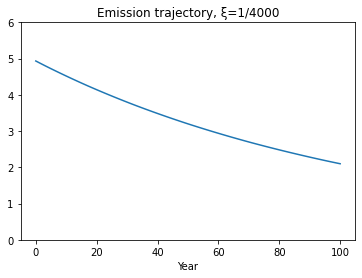

In [89]:
plt.figure()
plt.title('Emission trajectory, ξ=1/4000')
plt.plot(Et)
plt.xlabel('Year')
plt.ylim(0, 6)
plt.savefig('plot.pdf')
# plt.figure()
# plt.title('h trajectory')
# plt.plot(ht)
# plt.xlabel('Year')
# plt.figure()
# plt.title('trajectory of probability on low damage')
# plt.plot(πt)
# plt.xlabel('Year')

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])